# Install Dependencies

In [1]:
!pip install tensorflow==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-gpu==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [5]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [7]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [8]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1352273607483476690
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14436535534586564701
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [9]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [14]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

'C:\\Users\\utsav\\AppData\\Local\\Temp'

In [17]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)

Positive path:  C:\Users\utsav\AppData\Local\Temp\data\positive
Negative path:  C:\Users\utsav\AppData\Local\Temp\data\negative
Anchor path:  C:\Users\utsav\AppData\Local\Temp\data\anchor


In [30]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [21]:

#Uncompress Tar GZ Labelled Faces in the Wild Dataset

!tar -xf "C:\Users\utsav\Documents\lfw.tgz" --directory "C:\Users\utsav\Documents"

In [33]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir("C:/Users/utsav/Documents/lfw"):
    for file in os.listdir(os.path.join("C:/Users/utsav/Documents/lfw", directory)):
        EX_PATH = os.path.join("C:/Users/utsav/Documents/lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

#### Positive collection from webcam

In [34]:
# importing uuid library to geenrate unique image names
import uuid

In [35]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [36]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Load and Preprocess Images

#### Get images directories

In [37]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [38]:
dir_test = anchor.as_numpy_iterator()

In [39]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\4c095335-3535-11f0-a21f-c423607b4a5c.jpg'


#### Preprocessing - Scale and Resize

In [40]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [41]:
img = preprocess(dir_test.next())

In [45]:
img.numpy()

array([[[0.54901963, 0.5882353 , 0.5568628 ],
        [0.5392157 , 0.5872549 , 0.5480392 ],
        [0.5352941 , 0.5892157 , 0.5411765 ],
        ...,
        [0.5213235 , 0.5517157 , 0.5232843 ],
        [0.51985294, 0.5620098 , 0.53063726],
        [0.51666665, 0.5598039 , 0.52843136]],

       [[0.55196077, 0.59117645, 0.5598039 ],
        [0.5568628 , 0.6002451 , 0.56691176],
        [0.5357843 , 0.58504903, 0.54583335],
        ...,
        [0.51887256, 0.54632354, 0.51887256],
        [0.51593137, 0.55441177, 0.5232843 ],
        [0.50392157, 0.54607844, 0.5147059 ]],

       [[0.56421566, 0.59460783, 0.5632353 ],
        [0.55      , 0.5897059 , 0.5541667 ],
        [0.55514705, 0.59632355, 0.5541667 ],
        ...,
        [0.53333336, 0.5529412 , 0.5264706 ],
        [0.51740193, 0.5448529 , 0.5144608 ],
        [0.53333336, 0.5637255 , 0.5323529 ]],

       ...,

       [[0.35514706, 0.3767157 , 0.32769608],
        [0.34019607, 0.3629902 , 0.3259804 ],
        [0.34534314, 0

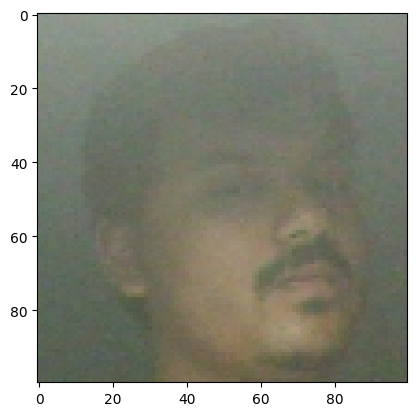

In [44]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [46]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [47]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [51]:
samples = data.as_numpy_iterator()

In [52]:
example = samples.next()

In [53]:
example

(b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\46bf6892-3535-11f0-bb51-c423607b4a5c.jpg',
 b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\positive\\3a90f61d-3535-11f0-a108-c423607b4a5c.jpg',
 1.0)